# Hyperbolic Embedding Methods for Medical Entity Relations
<br>

**Drew Wilimitis** <br> 
Department of Biomedical Informatics, Vanderbilt University Medical Center

![title](images/three_models.png)

### Abstract :
Electronic Health Records are other sources of clinical data are often unstructured, non-standardized, and contain heterogeneous data. This presents a significant challenge for building accurate and robust predictive models, as most standard supervised learning algorithms require uniformly formatted training datasets with informative feature vectors. Therefore, it is necessary to learn representations of these datasets that preserve their underlying, multi-layered relationships. There is a wide variety of methods for representation learning of Electronic Health Records **[1]**, including attempts to represent hierarchical relationships often found within taxonomies and concept networks. We compare a variety of hyperbolic embedding algorithms and their ability to learn low-distortion embeddings of ICD-9 codes. We then demonstrate the utility of these embeddings and the insights they reveal.

**Rough outline:**
2. Background Overview of Hyperbolic Geometry
3. Hyperbolic Embeddings <br>
a. Poincare Embedding Algorithm (gensim, pytorch) <br>
b. Lorentz Embedding (pytorch)<br>
c. Coalescent Embedding (laplacian based in R) <br>
d. Others: Lorentzian Distance Learning, hMDS, etc. <br>
4.  Evaluation Comparison (Between Euclidean & Earlier Approach) 
5. Apply Hyperbolic KMeans/Clustering?
6. Apply to real EHR data and build model with embedding features?

# Initial Data and Pre-processing Exploration

Here we begin to explore hyperbolic embeddings with a simpler test case - the standard ICD-9 taxonomy data given as a tree-like structure where edges denote the parent-child relationships found within hierarchical structures.

**data source:** https://github.com/kshedden/icd9

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [2]:
# Note: this approach includes all code levels (resulting in a lot more nodes and edges)
import json
sys.path.append('C:\\Users\\dreww\\Desktop')
from icd9 import icd9
from itertools import combinations
icd_data = icd9.icd9Hierarchy
drop_lettered_chapters = True # optionally drop supplemental lettered chapter codes
icd_data = [d for d in icd_data if d['icd9'][0] not in ['E', 'V']]

# store code ranges for each subchapter
subchapter_name_range = {}
for i, codes in enumerate(icd_data):
    try:
        if codes['subchapter'] not in subchapter_name_range.keys():
            if i > 0:
                subchapter_name_range[new_sub] = start + '_' + end
            new_sub = codes['subchapter']
            start = codes['threedigit']
        end = codes['threedigit']
    except KeyError:
        continue
subchapter_range_name = {v:k for k,v in subchapter_name_range.items()}

# store code ranges for each chapter
chapters = icd9.icd9Chapters
if drop_lettered_chapters:
    drop1 = chapters.pop('Supplementary Classification Of External Causes Of Injury And Poisoning')
    drop2 = chapters.pop('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

In [3]:
# get list of edge pairs
icd_relations = []
levels = {0:'icd9', 1: 'threedigit', 2: 'subchapter', 3: 'chapter'}
for codes in icd_data:
    for rel in combinations([1, 2, 3], 2): # using [0, 1, 2, 3] would include base-level codes
        try:
            edge = [codes[levels[rel[0]]], codes[levels[rel[1]]]]
            if edge not in icd_relations:
                icd_relations.append(edge)
        except KeyError:
            continue
            
# optionally add edges from each chapter to highest level, center node            
for chapter in chapter_name_range.values():
    icd_relations.append([chapter, 'ICD-9_Diagnoses'])

### Exploratory graph analysis with networkx
Now we define a graph with these relations as edges, and use `networkx` to examine the graph structure.

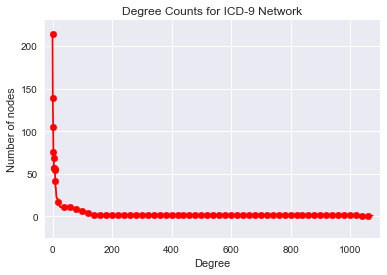

In [4]:
import collections
import networkx as nx
G = nx.Graph()
G.add_edges_from(icd_relations)

# degree sequence
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

# plot number of nodes that have given degree values
plt.figure()
plt.grid(True)
plt.plot(degree_sequence, 'r') # in-degree
node_ix = list(np.arange(0,10)) + list(np.arange(20, len(degree_sequence), 20))
plt.scatter(node_ix, np.array(degree_sequence)[node_ix], c='r', s=45)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Counts for ICD-9 Network')
plt.ylim([-25, 230])
plt.xlim([-25, 1100])
plt.show();

This distribution shows a heavily skewed distribution of in-degree, which indicates that the network has a hierarchical structure with a few central hub nodes (those that represent chapters in the taxonomy).

In [5]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G)
# Average clustering coefficient
ccs = nx.clustering(G)
avg_clust = sum(ccs.values()) / len(ccs)
print('Avg Clustering Coefficient:', avg_clust)

# get largest connected components in G
G_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
component_sizes = [len(c) for c in G_components]
print('{} connected component(s) with respective node sizes {}'.format(len(G_components),component_sizes))

component_graphs = [G.subgraph(c).copy() for c in G_components]
bc_vals = [np.mean(list(nx.betweenness_centrality(cg).values())) for cg in component_graphs]
print('Average betweenness centrality: ', np.mean(bc_vals))

Avg Clustering Coefficient: 0.8645680976529581
18 connected component(s) with respective node sizes [215, 140, 106, 77, 70, 58, 58, 57, 55, 43, 35, 35, 30, 24, 23, 21, 18, 11]
Average betweenness centrality:  0.02750867872437231


We also have a high clustering coefficient with a very low betweenness centrality - as one would expect to find within a cleanly defined tree-like structure with very minimal stochasticity.

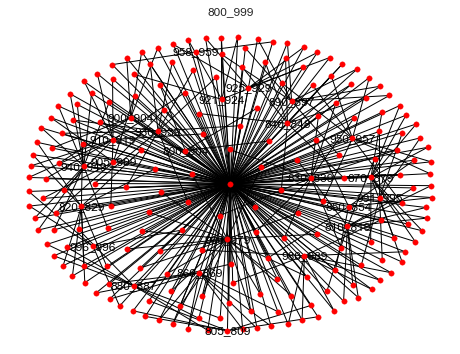

In [6]:
# now we select the first component and plot the sub-graph 
c = G_components[0]
C = G.subgraph(c).copy()

l1 = list(C.nodes())
subchaps = set(l1).intersection(set(subchapter_name_range.keys()))
sub_labels = {k:subchapter_name_range[k] for k in subchaps}
chaps = set(l1).intersection(set(chapter_name_range.keys()))
chap_labels = {k:chapter_name_range[k] for k in chaps}

# define figure with positions for all nodes
plt.figure(figsize=(8, 6))
pos=nx.kamada_kawai_layout(C)

# nodes and edges
nx.draw_networkx_nodes(C,pos,node_size=30)
nx.draw_networkx_edges(C,pos)

# add labels and plot
nx.draw_networkx_labels(C,pos,{s:sub_labels[s] for s in subchaps},font_size=12)
if len(list(chaps)) == 1:
    plt.title(chap_labels[list(chaps)[0]])
plt.axis('off')
plt.show(); # display

In [7]:
# define edge relations as a dataframe            
icd_df = pd.DataFrame(icd_relations, columns=['u', 'v'])
icd_df['u'] = icd_df.u.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: subchapter_name_range[x] if x in subchapter_name_range.keys() else x)
icd_df['v'] = icd_df.v.apply(lambda x: chapter_name_range[x] if x in chapter_name_range.keys() else x)
icd_df.head()
icd_df.info()
icd_df.to_csv('data/icd_data/icd_full_relations.csv', index=None)

,u,v
0,001,001_009
1,001,001_139
2,001_009,001_139
3,002,001_009
4,002,001_139


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       1956 non-null   object
 1   v       1956 non-null   object
dtypes: object(2)
memory usage: 30.7+ KB


In [8]:
# define mappings between chapter name & range to integer class labels
chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i
chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}

# assign each node to its chapter class label
node_labels = {}
for i in range(icd_df.shape[0]):
    u = icd_df.iloc[i, 0]
    v = icd_df.iloc[i, 1]
    if v in chapter_range_label.keys():
        node_labels[u] = chapter_range_label[v]
for k, v in chapter_range_label.items():
    node_labels[k] = v

### Train poincare embedding model and visualize 2-D embedding

In [9]:
# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils')
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\poincaré_embeddings')
from embed import *

In [19]:
# train poincare embeddings and save output embedding coordinates
fin = 'data/icd_data/icd_full_relations.csv' # input path with stored relations
fout = 'data/icd_data/icd_full_embeddings_tmp.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=100, burn_in_alpha=0.01, 
                 batch_size=10, burn_in=10, alpha=0.1, negative=20)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 1957 relations from train data, 1061 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 1957 relations for 100 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (100 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 1061x2 projection weights into data/icd_data/icd_full_embeddings_tmp.csv


In [156]:
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = load_embeddings('data/icd_data/icd_full_embeddings_tmp.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))

,node,x,y
0,800_999,-0.304720,-0.118744
1,001_139,0.453165,0.190884
2,140_239,0.665936,-0.607616
3,320_389,-0.790279,-0.566815
4,390_459,0.048185,-0.939577


In [157]:
sys.path.append('C:\\Users\\dreww\\Desktop\\vu-informatics\\utils')
from poincare_viz_icd import *
edge_list = [list(arr) for arr in np.array(icd_df)]
labels = emb[emb.node != 'ICD-9_Diagnoses'].node.apply(lambda x: node_labels[x])
chapter_label_range = {v:k for k,v in chapter_range_label.items()}

In [158]:
def plot_poincare_icd(emb, labels, edge_list, legend_headers=None, height=8, width=9, save=False,
                      plot_frac=1, edge_frac=1, add_labels=False, label_dict=None, title='Poincare Model', label_frac=0.001):
    # Note: parameter 'emb' expects data frame with node ids and coords
    emb.columns = ['node', 'x', 'y']
    n_classes = len(np.unique(labels))
    plt.figure(figsize=(width, height))
    plt.xlim([-1.0, 1.0])
    plt.ylim([-1.0,1.0])
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.8)
    ax.add_patch(circ)
    
    # set colormap,
    if n_classes <= 12:
        colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'silver', 'lime', 'skyblue', 'maroon', 'darkorange']
    elif 12 < n_classes <= 20:
        colors = [i for i in plt.cm.get_cmap('tab20').colors]
    else:
        cmap = plt.cm.get_cmap(name='viridis')
        colors = cmap(np.linspace(0, 1, n_classes))

    # plot embedding coordinates
    emb_data = np.array(emb[emb.node != 'ICD-9_Diagnoses'].iloc[:, 1:3])
    for i in range(n_classes):
        plt.scatter(emb_data[(labels == i), 0], emb_data[(labels == i), 1], color = colors[i],
                    alpha=0.9, edgecolors='black', s=75, label=i)
    # plot central highest level node
    center_coords = emb[emb.node == 'ICD-9_Diagnoses'].iloc[:, 1:3].values[0]
    label_dict['ICD-9_Diagnoses'] = center_coords
    plt.scatter(center_coords[0], center_coords[1], s=70, c='black')
    
    # plot edges
    for i in range(int(len(edge_list) * edge_frac)):
        x1 = emb.loc[(emb.iloc[:, 0] == edge_list[i][0]), ['x', 'y']].values[0]
        x2 = emb.loc[(emb.node == edge_list[i][1]), ['x', 'y']].values[0]
        _ = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], '--', c='black', linewidth=1, alpha=0.55)
    
    # add labels to embeddings,
    if add_labels and label_dict != None:
        plt.grid('off')
        plt.axis('off')
        embed_vals = np.array(list(label_dict.values()))
        keys = list(label_dict.keys())
        # set threshhold to limit plotting labels too close together
        min_dist_2 = label_frac * max(embed_vals.max(axis=0) - embed_vals.min(axis=0)) ** 2
        labeled_vals = np.array([2*embed_vals.max(axis=0)])
        n = int(plot_frac*len(embed_vals))
        for i in np.random.permutation(len(embed_vals))[:n]:
            if np.min(dist_squared(embed_vals[i], labeled_vals, axis=1)) < min_dist_2:
                continue
            else:
                props = dict(boxstyle='round', lw=1, edgecolor='black', alpha=0.65)
                _ = ax.text(embed_vals[i][0], embed_vals[i][1]+0.06, s=keys[i],
                            size=10, fontsize=10, verticalalignment='top', bbox=props)
                labeled_vals = np.vstack((labeled_vals, embed_vals[i]))
    plt.suptitle('Hyperbolic ICD-9 Embedding: ' + title, size=20)
    leg_handles, leg_labels = ax.get_legend_handles_labels()
    if legend_headers != None:
        # get display labels and put legend to the right of the current axis
        new_labels = [legend_headers[int(l)] for l in leg_labels]
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
        ax.legend(leg_handles, new_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=14,
                  frameon=True, edgecolor='black', fancybox=True, framealpha=1, shadow=True, borderpad=1)
    if save:
        plt.savefig('images/' + title.replace(' ', '_') + '.png')
    plt.show();

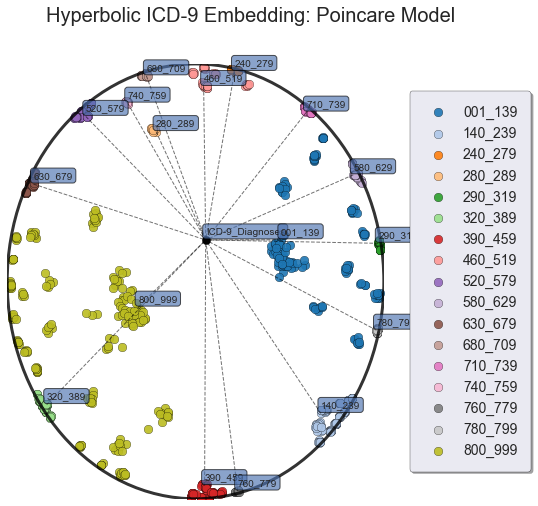

In [159]:
# add labels for chapters and select only high level edges
chapter_emb = emb[emb.node.apply(lambda x: x in list(chapter_range_name.keys()))]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if 'ICD-9_Diagnoses' in e]

plot_poincare_icd(emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  legend_headers=chapter_label_range, save=False)

### Training Hyperbolic Embeddings with HyperMap and LaBNE 

A recently established hyperbolic embedding approach is a hybrid method that utilizes both maximum likelihood estimation (HyperMap) and Laplacian based methods (LaBNE) within hyperbolic space **[5]**.<br>

The embedding algorithm that I use is provided by the following open source repository with accessible R code and an underlying c++ implementation that produces efficient embeddings in hyperbolic space. 

**code source:** https://github.com/galanisl/NetHypGeom/blob/master/R/labne_hm.R

In [38]:
def load_hyp_embedding(file):
    # read in embedding coordinates
    emb = pd.read_csv(file).drop(['Unnamed: 0'], axis=1)
    # scale within poincare ball
    emb['r'] = emb.r / np.max(emb.r) - 1e-2
    # get cartesian coordinates
    x = []
    y = []
    for i in range(emb.shape[0]):
        x.append(emb.r[i]*np.cos(emb.theta[i]))
        y.append(emb.r[i]*np.sin(emb.theta[i]))
    emb['x'] = x
    emb['y'] = y
    emb.columns = ['node', 'r', 'theta', 'x', 'y']
    return emb
hyper_emb = load_hyp_embedding('data/icd_data/hypermap_embedding.csv').drop(['r', 'theta'], axis=1)
hyper_emb.head()
hyper_emb_dict = dict(zip(hyper_emb.node.values, np.array(hyper_emb.iloc[:, 1:3])))
laplacian_emb = load_hyp_embedding('data/icd_data/laplacian_embedding.csv').drop(['r', 'theta'], axis=1)
laplacian_emb_dict = dict(zip(laplacian_emb.node.values, np.array(laplacian_emb.iloc[:, 1:3])))
laplacian_emb.head()

,node,x,y
0,001,0.896993,-0.100559
1,001_009,0.727233,-0.077379
2,002,0.893619,-0.088584
3,003,0.900062,-0.106714
4,004,0.881590,-0.102420


,node,x,y
0,001,-0.137783,-0.892034
1,001_009,-0.109264,-0.723130
2,002,-0.147927,-0.885731
3,003,-0.120773,-0.898284
4,004,-0.130722,-0.877840


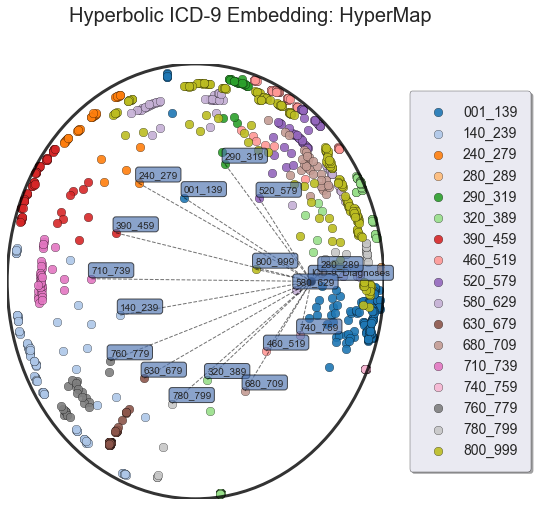

In [39]:
# add labels for chapters and select only high level edges
chapter_emb = hyper_emb[hyper_emb.node.apply(lambda x: x in list(chapter_range_name.keys()))]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if 'ICD-9_Diagnoses' in e]
labels = hyper_emb[hyper_emb.node != 'ICD-9_Diagnoses'].node.apply(lambda x: node_labels[x])

plot_poincare_icd(hyper_emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  legend_headers=chapter_label_range, save=False, title='HyperMap')

The embedding produced by HyperMap appears to be less effective at representing the hierarchical network than the Poincare embedding model, but clearly displays a visual reconstruction of the ICD-9 taxonomy. The HyperMap embedding could likely be improved with more hyperparameter tuning, however; it is interesting to notice how HyperMap attempts to preserve similarities by their angular displacement and does so moderately well on this embedding task.

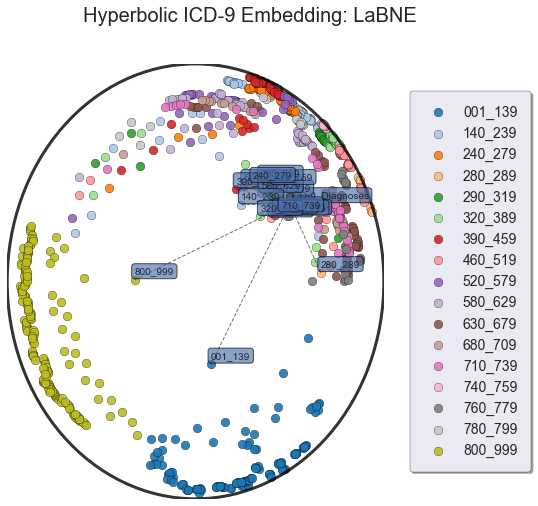

In [40]:
# add labels for chapters and select only high level edges
chapter_emb = laplacian_emb[laplacian_emb.node.apply(lambda x: x in list(chapter_range_name.keys()))]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if 'ICD-9_Diagnoses' in e]
labels = laplacian_emb[laplacian_emb.node != 'ICD-9_Diagnoses'].node.apply(lambda x: node_labels[x])

plot_poincare_icd(laplacian_emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  legend_headers=chapter_label_range, save=False, title='LaBNE')

This embedding is primarily based on LaBNE (Laplacian Based Network Embedding) within hyperbolic space, along with a radial adjustment added by HyperMap. Again, this seemingly poor representation of the ICD-9 taxonomy in hyperbolic space could very well be improved by more intelligent hyperparameter selection. The spectral decomposition along a few selected eigenvectors could explain the inability to separate a large number of categorical groups.

## Evaluate Hyperbolic Embeddings

A good embedding of the ICD-9 taxonomy will preserve the hierarchical relationships between entities (diagnosis codes). Working with the embeddings in the poincare disk, we compute the pairwise hyperbolic distances between points within the same chapter or subchapter, and then we compare these with the hyperbolic distances between different chapters and subchapters. If points within the same diagnosis group are closer together in hyperbolic space, relative to the intergroup distances, then our embedding will have preserved similarities and hierarchical relationships in the ICD-9 taxonomy.  

In [75]:
def get_chapter_nodes(chapter, edge_list):
    """ Return the set of nodes within a given chapter
    Parameters
    ----------
    chapter : must be given in range notation, e.g. '001_139'
    edge_list: list of [u, v] edge pairs
    """
    child_nodes = [e[0] for e in edge_list if e[1] == chapter]
    return child_nodes

def within_chapter_distances(chapter_nodes, embedding_dict):
    # compute all pairwise hyperbolic distances
    D = poincare_distances(np.array([embedding_dict[x] for x in chapter_nodes]))
    mean_dist = D[D>0].mean()
    std_dev = D[D>0].std()
    return [mean_dist, std_dev]

def get_subchapter_nodes(subchapter, edge_list):
    """ Return the set of nodes within a given subchapter
    Parameters
    ----------
    subchapter : must be given in range notation, e.g. '001_007'
    edge_list: list of [u, v] edge pairs
    """
    child_nodes = [e[0] for e in edge_list if e[1] == subchapter]
    return child_nodes

def within_subchapter_distances(subchapter_nodes, embedding_dict):
    # compute all pairwise hyperbolic distances
    if len(subchapter_nodes) <= 1:
        return
    else:
        D = poincare_distances(np.array([embedding_dict[x] for x in subchapter_nodes]))
        mean_dist = D[D>0].mean()
        std_dev = D[D>0].std()
    return [mean_dist, std_dev]

In [76]:
def between_chapter_distances(chapter_nodes, embedding, dist_matrix):
    # compute all pairwise hyperbolic distances
    embedding = embedding[embedding.node != 'ICD-9_Diagnoses'].reset_index(drop=True)
    in_group_indices = embedding[embedding.node.apply(lambda x: x in chapter_nodes)].index
    rows = np.arange(0, dist_matrix.shape[0])
    out_group_indices = list(set(rows).difference(in_group_indices))
    between_dists = [dist_matrix[ix, out_group_indices] for ix in in_group_indices]
    mean_dist = np.mean(between_dists)
    std_dev = np.std(between_dists)
    return [mean_dist, std_dev]

def between_subchapter_distances(subchapter_nodes, embedding, dist_matrix):
    # compute all pairwise hyperbolic distances
    embedding = embedding[embedding.node != 'ICD-9_Diagnoses'].reset_index(drop=True)
    in_group_indices = embedding[embedding.node.apply(lambda x: x in subchapter_nodes)].index
    rows = np.arange(0, dist_matrix.shape[0])
    out_group_indices = list(set(rows).difference(in_group_indices))
    between_dists = [dist_matrix[ix, out_group_indices] for ix in in_group_indices]
    mean_dist = np.mean(between_dists)
    std_dev = np.std(between_dists)
    return [mean_dist, std_dev]

In [77]:
def chapter_metrics(embedding_dict, edge_list, dist_matrix):
    # calculate within chapter metrics
    within_chapter_metrics = {'mean_dists': [], 'std_dev': []}
    for chapter in chapter_range_name.keys():
        chapter_nodes = get_chapter_nodes(chapter, edge_list)
        mean, std = within_chapter_distances(chapter_nodes, embedding_dict)
        within_chapter_metrics['mean_dists'].append(mean)
        within_chapter_metrics['std_dev'].append(std)
    mean_dist_within = np.mean(within_chapter_metrics['mean_dists'])
    std_dev_within = np.mean(within_chapter_metrics['std_dev'])
    
    # calculate between chapter metrics
    emb = pd.DataFrame([[k, v[0], v[1]] for k,v in embedding_dict.items()], columns=['node', 'x', 'y'])
    between_chapter_metrics = {'mean_dists': [], 'std_dev': []}
    for chapter in chapter_range_name.keys():
        chapter_nodes = get_chapter_nodes(chapter, edge_list)
        mean, std = between_chapter_distances(chapter_nodes, emb, dist_matrix)
        between_chapter_metrics['mean_dists'].append(mean)
        between_chapter_metrics['std_dev'].append(std)
    mean_dist_between = np.mean(between_chapter_metrics['mean_dists'])
    std_dev_between = np.mean(between_chapter_metrics['std_dev'])
    return [np.round(x, 3) for x in [mean_dist_within, std_dev_within, mean_dist_between, std_dev_between]]

def subchapter_metrics(embedding_dict, edge_list, dist_matrix):
    # calculate within group metrics
    within_subchapter_metrics = {'mean_dists': [], 'std_dev': []}
    for subchapter in subchapter_range_name.keys():
        subchapter_nodes = get_subchapter_nodes(subchapter, edge_list)
        if len(subchapter_nodes) <= 1:
            continue
        else:
            mean, std = within_subchapter_distances(subchapter_nodes, embedding_dict)
            within_subchapter_metrics['mean_dists'].append(mean)
            within_subchapter_metrics['std_dev'].append(std)
    mean_dist_within = np.mean(within_subchapter_metrics['mean_dists'])
    std_dev_within = np.mean(within_subchapter_metrics['std_dev'])
    
    # calculate between group metrics
    emb = pd.DataFrame([[k, v[0], v[1]] for k,v in embedding_dict.items()], columns=['node', 'x', 'y'])
    between_subchapter_metrics = {'mean_dists': [], 'std_dev': []}
    for subchapter in subchapter_range_name.keys():
        subchapter_nodes = get_subchapter_nodes(subchapter, edge_list)
        if len(subchapter_nodes) <= 1:
            continue
        else:
            mean, std = between_subchapter_distances(subchapter_nodes, emb, dist_matrix)
            between_subchapter_metrics['mean_dists'].append(mean)
            between_subchapter_metrics['std_dev'].append(std)
    mean_dist_between = np.mean(between_subchapter_metrics['mean_dists'])
    std_dev_between = np.mean(between_subchapter_metrics['std_dev'])
    return [np.round(x, 3) for x in [mean_dist_within, std_dev_within, mean_dist_between, std_dev_between]]

In [78]:
def evaluate_embedding(embedding_dict, edge_list):
    # need to define pairwise distances for each embedding
    emb_data = np.array(list(embedding_dict.values()))
    D = poincare_distances(emb_data)
    D_symm = D.T + D
    
    # store all chapter and subchapter metrics
    eval_metrics = {}
    eval_metrics['chapter'] = chapter_metrics(embedding_dict, edge_list, D_symm)
    eval_metrics['subchapter'] = subchapter_metrics(embedding_dict, edge_list, D_symm)
    return eval_metrics

embedding_dicts = [emb_dict, hyper_emb_dict, laplacian_emb_dict]
embeddings = ['Poincare', 'HyperMap', 'LaBNE']
overall_metrics = {}
for i in range(len(embeddings)):
    overall_metrics[embeddings[i]] = evaluate_embedding(embedding_dicts[i], edge_list)
overall_metrics

{'Poincare': {'chapter': [1.702, 1.022, 7.307, 2.036],
  'subchapter': [0.255, 0.138, 6.871, 2.125]},
 'HyperMap': {'chapter': [1.882, 1.152, 5.375, 1.661],
  'subchapter': [0.25, 0.154, 5.193, 1.727]},
 'LaBNE': {'chapter': [2.117, 1.367, 4.791, 1.653],
  'subchapter': [0.641, 0.436, 4.889, 1.76]}}

In [79]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Embedding", "Category", "Within Category", "Outside Category"]
val_lists = [[overall_metrics[k]['chapter'], overall_metrics[k]['subchapter']] for k in overall_metrics.keys()]
for i, l in enumerate(val_lists):
    v1 = str(l[0][0]) + ' (' + str(l[0][1]) + ')'
    v2 = str(l[0][2]) + ' (' + str(l[0][3]) + ')'
    v3 = str(l[1][0]) + ' (' + str(l[1][1]) + ')'
    v4 = str(l[1][2]) + ' (' + str(l[1][3]) + ')'
    x.add_row([embeddings[i], 'Chapter', v1, v2])
    x.add_row([embeddings[i], 'Subchapter', v3, v4])
print(x)

+-----------+------------+-----------------+------------------+
| Embedding |  Category  | Within Category | Outside Category |
+-----------+------------+-----------------+------------------+
|  Poincare |  Chapter   |  1.702 (1.022)  |  7.307 (2.036)   |
|  Poincare | Subchapter |  0.255 (0.138)  |  6.871 (2.125)   |
|  HyperMap |  Chapter   |  1.882 (1.152)  |  5.375 (1.661)   |
|  HyperMap | Subchapter |   0.25 (0.154)  |  5.193 (1.727)   |
|   LaBNE   |  Chapter   |  2.117 (1.367)  |  4.791 (1.653)   |
|   LaBNE   | Subchapter |  0.641 (0.436)  |   4.889 (1.76)   |
+-----------+------------+-----------------+------------------+


## Apply Hyperbolic K-Means Clustering to Poincare Embeddings

Given an accurate and informative embedding of the ICD-9 dataset in hyperbolic space, we can now apply clustering methods like Hyperbolic K-Means, which is adapted specifically to the poincare distance metric and hyperbolic notions of a barycentric mean. They often outperforms Euclidean clustering methods in this context, and there are many potential ways in which hyperbolic clustering methods could discover insightful, counter-intuitive segmentations, produce novel ways to visualize and explore latent characteristics of unstructured data, and also provide informative features that improve downstream prediction tasks.  

In [154]:
# fit hyperbolic kmeans clusters to embedding vectors
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\hyperbolic_kmeans')
from hkmeans import HyperbolicKMeans, plot_clusters
hkmeans = HyperbolicKMeans(n_clusters=17)
hkmeans.fit(emb_data, max_epochs=5)

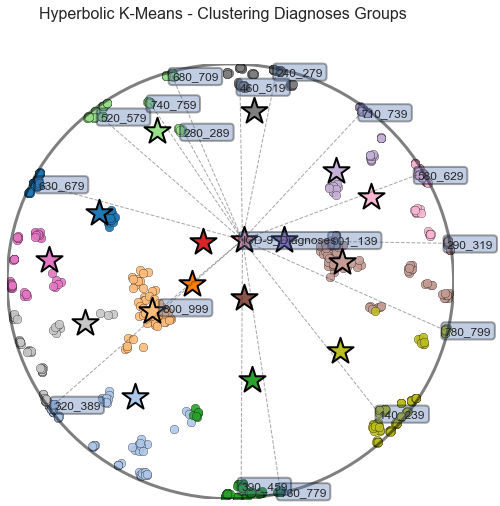

In [160]:
# plot results
plot_clusters(emb, labels = hkmeans.assignments, centroids = hkmeans.centroids, edge_list=chapter_edges,
              add_labels=True, label_dict=chapter_emb_dict, label_frac = 0.001, edge_frac = 1,
              width=8, height=8, title='Clustering Diagnoses Groups')

Hyperbolic K-Means is able to learn pretty accurate clusterings of the true diagnostic categories, in an unsupervised manner. The number of different classes makes this particularly challenging, but its overall performance and efficiency warrants further investigation into potential applications and extensions.

## Applications with a real world EHR dataset

We have a dataset that includes demographic information,
diagnoses, and Emergency Department (ED) visits for a cohort of
patients over the period 2010-2012.

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient


(5893, 7)

Number of unique patients:  400
Avg number of diagnoses per person:  14.7325


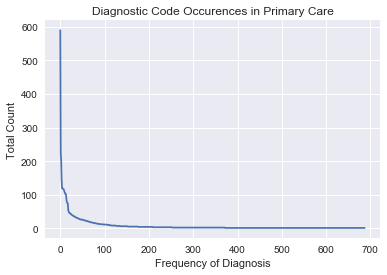

In [206]:
# this dataset contains information on the date and nature of primary diagnoses
diag = pd.read_csv('data/Harvard EHR Dataset/dia.csv')
diag.head()
diag.shape
print('Number of unique patients: ', diag.empi.nunique())
print('Avg number of diagnoses per person: ', diag.groupby('empi').count()['dia_code'].mean())
y = diag.dia_code.value_counts().sort_values(ascending=False).values
x = np.arange(0, len(diag.dia_code.unique()))
_ = plt.plot(x, y)
_ = plt.ylabel('Total Count')
_ = plt.xlabel('Frequency of Diagnosis')
_ = plt.title('Diagnostic Code Occurences in Primary Care')

In [204]:
# this dataset contains demographic information and indication of mortality
dem = pd.read_csv('data/Harvard EHR Dataset/dem.csv')
dem.head()
dem.shape
dem.date_of_death.isna().sum()
dem.info()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,NaN,NaN
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,NaN,NaN
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,NaN,NaN
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,NaN,NaN
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,NaN,NaN


(400, 8)

265

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   empi           400 non-null    int64 
 1   name           400 non-null    object
 2   gender         400 non-null    object
 3   date_of_birth  400 non-null    object
 4   age            400 non-null    int64 
 5   race           400 non-null    object
 6   vital_status   135 non-null    object
 7   date_of_death  135 non-null    object
dtypes: int64(2), object(6)
memory usage: 25.1+ KB


In [194]:
# this dataset describes emergency department visits, icd9 codes with descriptions, and clinical notes 
ed_notes = pd.read_csv('data/Harvard EHR Dataset/ed_visits.txt', delimiter='$')
ed_notes.head()
ed_notes.info()

,empi,visit_date,admit_date,discharge_date,length_of_stay,principal_dia_code,principal_dia_name,additional_dia_code,note_text
0,940785937,2013-05-14,2013-05-14 23:59:19,2013-05-15 00:52:57,54,724.2,Lumbago,"719.46,786.2,786.2,V62.85",[report_beginning]\n\n940785937|2013-05-14|fin...
1,412857024,2012-01-20,2012-01-20 22:53:54,2012-01-21 02:51:49,238,781.0,Abnormal involuntary movements,NaN,[report_beginning]\n\n412857024|2012-01-20|fin...
2,285331782,2011-12-09,2011-12-09 12:54:56,2011-12-09 17:37:59,283,786.59,Other chest pain,"996.73,719.46,724.2,959.09",[report_beginning]\n\n285331782|2011-12-09|fin...
3,916658044,2011-05-23,2011-05-23 14:12:04,2011-05-23 21:21:44,430,780.4,Dizziness and giddiness,"719.46,820.8,789.01,780.50",[report_beginning]\n\n916658044|2011-05-23|fin...
4,172824291,2012-09-30,2012-09-30 03:44:42,2012-09-30 07:32:36,228,789.02,"Abdominal pain, left upper quadrant","540.9,998.30,784.2,578.9",[report_beginning]\n\n172824291|2012-09-30|uns...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   empi                 869 non-null    int64 
 1   visit_date           861 non-null    object
 2   admit_date           869 non-null    object
 3   discharge_date       869 non-null    object
 4   length_of_stay       869 non-null    int64 
 5   principal_dia_code   869 non-null    object
 6   principal_dia_name   869 non-null    object
 7   additional_dia_code  853 non-null    object
 8   note_text            869 non-null    object
dtypes: int64(2), object(7)
memory usage: 61.2+ KB


principal_dia_code     308
additional_dia_code    831
dtype: int64

1135

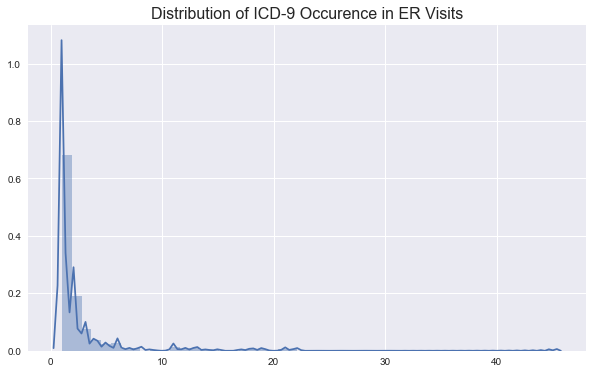

In [208]:
diagnoses = ed_notes.principal_dia_code.value_counts().reset_index()
diagnoses.columns = ['icd_code', 'occurences']
ed_notes[['principal_dia_code', 'additional_dia_code']].nunique()
len(np.unique(ed_notes.dropna()[['principal_dia_code', 'additional_dia_code']].values))
_ = plt.figure(figsize=(10,6))
_ = plt.title('Distribution of ICD-9 Occurence in ER Visits', size=16)
_ = sns.distplot(diagnoses.occurences.values)

Algebraic Connectivity:  0.4174408777083661
Average Clustering:  0.18187059519248722


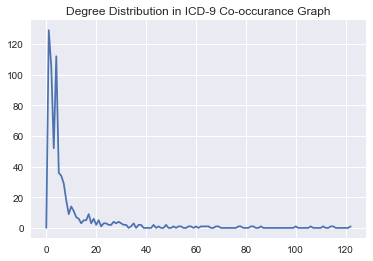

In [210]:
# define edge pairs from secondary codes to primary icd code
edges = []
for i in range(len(ed_notes)):
    if ed_notes.iloc[i].isna().sum() > 0:
        continue
    primary_code = ed_notes.principal_dia_code[i]
    if ',' in ed_notes.additional_dia_code[i]:
        secondary_codes = ed_notes.additional_dia_code[i].split(",")
        for code in secondary_codes:
            edges.append([code, primary_code])
    else:
        edges.append([ed_notes.additional_dia_code[i], primary_code])
G = nx.Graph(edges)
print('Algebraic Connectivity: ', nx.algebraic_connectivity(G))
print('Average Clustering: ', nx.average_clustering(G))
plt.plot(nx.degree_histogram(G))
plt.title('Degree Distribution in ICD-9 Co-occurance Graph');

In [283]:
# get unique icd codes
node_list = []
add_codes = np.array(ed_notes['additional_dia_code'].dropna().apply(lambda x: x.split(',') if ',' in x else x))
for l in add_codes:
    node_list += l
nodes = list(set(node_list).union(list(np.ravel(np.array(ed_notes['principal_dia_code'].values)))))
len(nodes)
len(edges)

667

3412

In [291]:
# define a co-occurence matrix where M[i,j] gives total co-occurences between nodes i,j 
M = np.zeros((667, 667))
node_to_index = dict(zip(nodes, np.arange(len(nodes))))
for e in edges:
    M[node_to_index[e[0]], node_to_index[e[1]]] += 1

10.0

___
### References: <br>


**[1]**. Weng, Wei-Hung and Peter Szolovits. “Representation Learning for Electronic Health Records.” ArXiv abs/1909.09248 (2019): n. pag.

**[2]** Beaulieu-Jones, Brett & Kohane, Isaac & Beam, Andrew. (2019). Learning Contextual Hierarchical Structure of Medical Concepts with Poincairé Embeddings to Clarify Phenotypes. Pacific Symposium on Biocomputing. Pacific Symposium on Biocomputing. 24. 8-17. 

**[3]** Cao, Jiazhen. “A Case Study for Predicting in-Hospital Mortality by Utilizing the Hyperbolic Embedding of ICD-9 Medical Ontology.” (2019).

**[4]** Learning Electronic Health Records through Hyperbolic Embedding of Medical Ontologies: https://dl.acm.org/doi/pdf/10.1145/3307339.3342148

**[5]** Alanis-Lobato, G., Mier, P. & Andrade-Navarro, M. Manifold learning and maximum likelihood estimation for hyperbolic network embedding. Applied Network Science 1(10) (2016)

<br>
___